In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
import nltk
from nltk.corpus import stopwords
import re
import joblib
from keras.preprocessing.text import Tokenizer
import gensim
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report


Using TensorFlow backend.


In [3]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",encoding='latin-1',header=None)

In [4]:
columns=['target','ids','date','flag','user','text']
df.columns=columns

In [5]:
df.target.replace({0:'Negative',2:'Neutral',4:'Positive'},inplace=True)

In [6]:
stop_words=set(stopwords.words('english'))
stop_words.remove('not')

In [7]:
corpus=[]
for i in range(0,len(df)):
    review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',df['text'][i])
    review=review.lower()
    review=review.split()
    review=[word for word in review if not word in stop_words]
    review=' '.join(review)
    corpus.append(review)

In [8]:
df.text=corpus

In [9]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(df,test_size=0.20,random_state=123)

In [10]:
documents = [text.split() for text in train_df.text]

In [11]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [12]:
w2v_model.build_vocab(documents)

In [13]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30446


In [14]:
w2v_model.train(documents, total_examples=len(documents), epochs=30)

(248017180, 279410310)

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df.text)

In [16]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

290653

In [17]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df.text), maxlen=300)

In [18]:
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df.text), maxlen=300)

In [19]:
y_train=train_df.target

In [20]:
y_test=test_df.target

In [21]:
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test=labelencoder.fit_transform(y_test)

In [22]:
y_train.shape

(1280000,)

In [23]:
y_test.shape

(320000,)

In [24]:
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        
print(embedding_matrix.shape)

(290653, 300)


In [25]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [26]:
from keras.layers import Bidirectional

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87195900  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 87,516,901
Trainable params: 321,001
Non-trainable params: 87,195,900
_________________________________________________________________


In [27]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [28]:
model_history=model.fit(X_train, y_train,batch_size=1024,epochs=15,validation_split=0.1,verbose=1)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/15
1152000/1152000 [==============================] - 641s 556us/step - loss: 0.5006 - accuracy: 0.7527 - val_loss: 0.4556 - val_accuracy: 0.7858
Epoch 2/15
1152000/1152000 [==============================] - 633s 550us/step - loss: 0.4731 - accuracy: 0.7713 - val_loss: 0.4447 - val_accuracy: 0.7907
Epoch 3/15
1152000/1152000 [==============================] - 632s 549us/step - loss: 0.4662 - accuracy: 0.7758 - val_loss: 0.4405 - val_accuracy: 0.7931
Epoch 4/15
1152000/1152000 [==============================] - 632s 549us/step - loss: 0.4618 - accuracy: 0.7786 - val_loss: 0.4378 - val_accuracy: 0.7946
Epoch 5/15
1152000/1152000 [==============================] - 632s 549us/step - loss: 0.4633 - accuracy: 0.7777 - val_loss: 0.4369 - val_accuracy: 0.7943
Epoch 6/15
1152000/1152000 [==============================] - 630s 547us/step - loss: 0.4588 - accuracy: 0.7804 - val_loss: 0.4351 - val_accuracy: 0.7960
Epoch 7/15
1152000/1152

In [29]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs=range(len(acc))

Text(0.5, 1.0, 'Training and Validation loss')

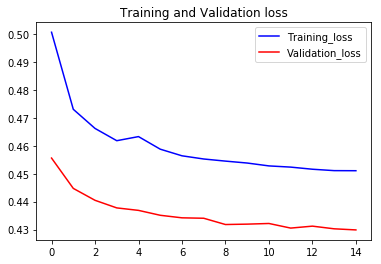

In [30]:
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

In [31]:
def preprocess(text):
    review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',text)
    review=review.lower()
    review=review.split()
    review=[word for word in review if not word in stop_words]
    print(review)
    review=pad_sequences(tokenizer.texts_to_sequences([review]), maxlen=300)
    return review

In [32]:
def prediction(review):
    review=preprocess(review)
    score=model.predict(review)
    score=score[0]
    if score<0.4:
        print("Negative")
    elif score>0.4 and score<0.6:
        print("Neutral")
    else:
        print("Positive")
    print(score)

In [33]:
prediction("the classrooms are not clean")

['classrooms', 'not', 'clean']
Negative
[0.21796505]


In [34]:
scores = model.predict(X_test, verbose=1, batch_size=1024)

320000/320000 [==============================] - 43s 133us/step


In [35]:
y_pred=np.where(scores>0.5,1,0)

In [36]:
print(accuracy_score(y_pred,y_test))

0.798028125


In [37]:
joblib.dump(w2v_model,'word2vec.pkl')
joblib.dump(tokenizer,'tokenizer.pkl')
joblib.dump(model,'final_model.pkl')

['final_model.pkl']

In [38]:
from keras.models import load_model

In [39]:
model.save('final_model_new.h5')